In [1]:
import os
import gc
import time
import numpy as np; np.random.seed(42)
import pandas as pd
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [21]:
logger = open(f"../logs/pipeline-level12-{datetime.now()}", "w")

***
# Input data

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

***
# Models configuration

In [3]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "event_type_1",
    "event_name_2",
    "event_type_2"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

In [22]:
logger.write("#"*100+"\n")
logger.write(" MODEL CONFIGURATION ".center(100, "#")+"\n")
logger.write("#"*100+"\n\n")
logger.write(f"- model_params: \n{model_params}\n\n")
logger.write(f"- time_features: \n{model_kwargs['time_features']}\n\n")
logger.write(f"- lags: \n{model_kwargs['lags']}\n\n")
logger.write(f"- window_functions: \n{model_kwargs['window_functions']}\n\n")
logger.write(f"- window_shifts: \n{model_kwargs['window_shifts']}\n\n")
logger.write(f"- window_sizes: \n{model_kwargs['window_sizes']}\n\n")
logger.write(f"- categorical_features: \n{model_kwargs['categorical_features']}\n\n")
logger.flush()

***

In [4]:
valid_periods = [
    (pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
    (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
    (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22")),
]

In [24]:
    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


In [26]:
valid_periods[1]

(Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00'))

####################################################################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.736982	valid_0's wrmsse: 0.803809
[50]	valid_0's wrmsseL12: 0.67989	valid_0's wrmsse: 0.509996
[75]	valid_0's wrmsseL12: 0.67117	valid_0's wrmsse: 0.484938
[100]	valid_0's wrmsseL12: 0.668557	valid_0's wrmsse: 0.471045
[125]	valid_0's wrmsseL12: 0.668541	valid_0's wrmsse: 0.467422
[150]	valid_0's wrmsseL12: 0.668147	valid_0's wrmsse: 0.464508
[175]	valid_0's wrmsseL12: 0.667758	valid_0's wrmsse: 0.460968
[200]	valid_0's wrmsseL12: 0.667289	valid_0's wrmsse: 0.456702
[225]	valid_0's wrmsseL12: 0.66682	valid_0's wrmsse: 0.45455
[250]	valid_0's wrmsseL12: 0.66668	valid_0's wrmsse: 0.45

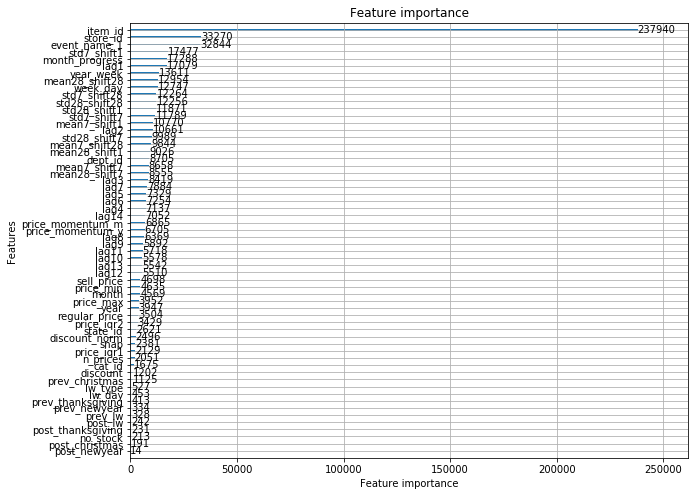

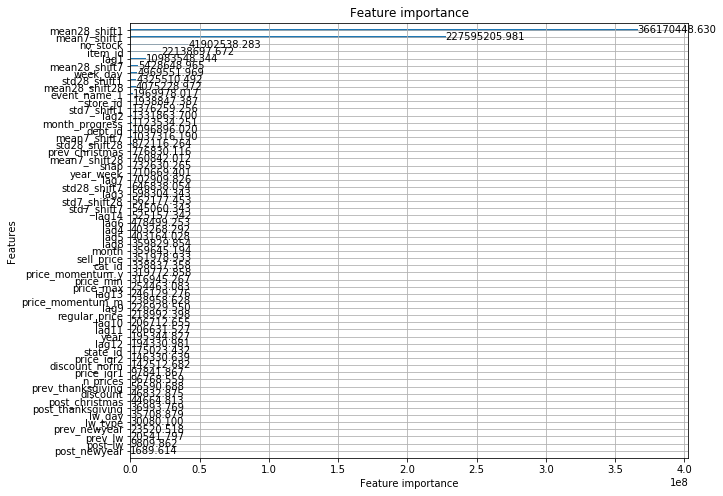

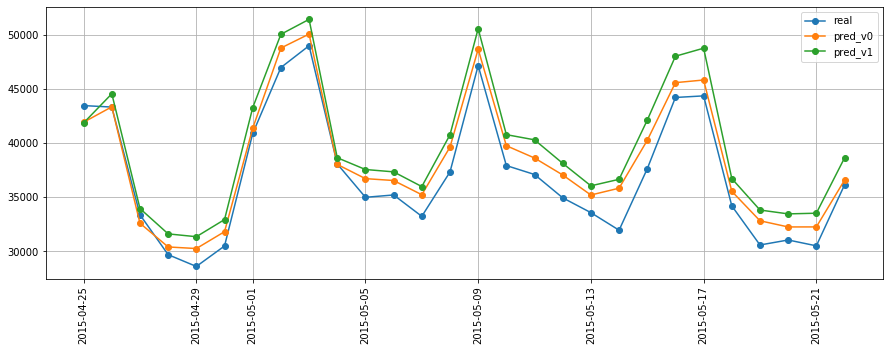

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Fitting the model
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.753245	valid_0's wrmsse: 0.944989
[50]	valid_0's wrmsseL12: 0.692876	valid_0's wrmsse: 0.652383
[75]	valid_0's wrmsseL12: 0.684135	valid_0's wrmsse: 0.597213
[100]	valid_0's wrmsseL12: 0.682051	valid_0's wrmsse: 0.574751
[125]	valid_0's wrmsseL12: 0.682547	valid_0's wrmsse: 0.565559
[150]	valid_0's wrmsseL12: 0.682504	valid_0's wrmsse: 0.560783
[175]	valid_0's wrmsseL12: 0.682222	valid_0's wrmsse: 0.55615
[200]	valid_0's wrmsseL12: 0.68201	valid_0's wrmsse: 0.553271
[225]	valid_0's wrmsseL12: 0.681332	valid_0's wrmsse: 0.550428
[250]	valid_0's wrmsseL12: 0.680902	valid_0's wrmsse: 0

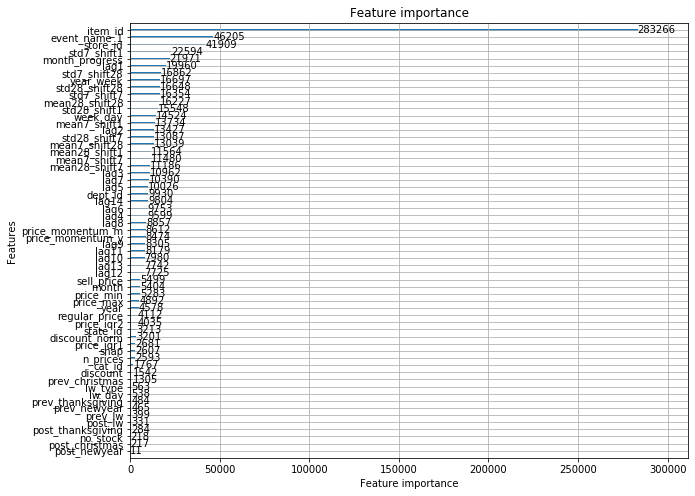

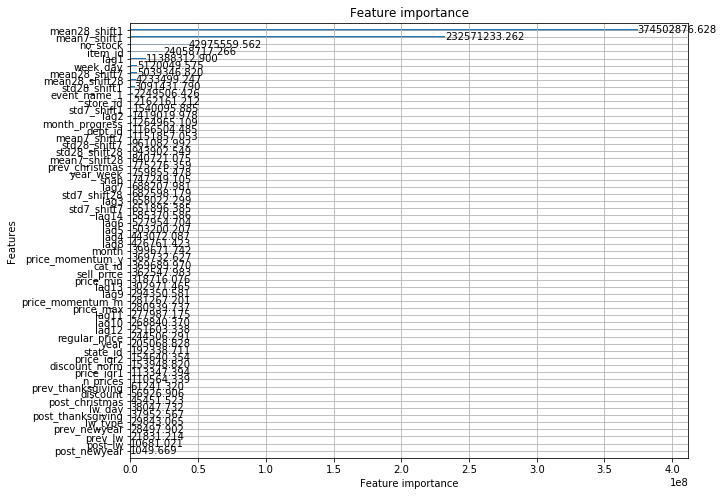

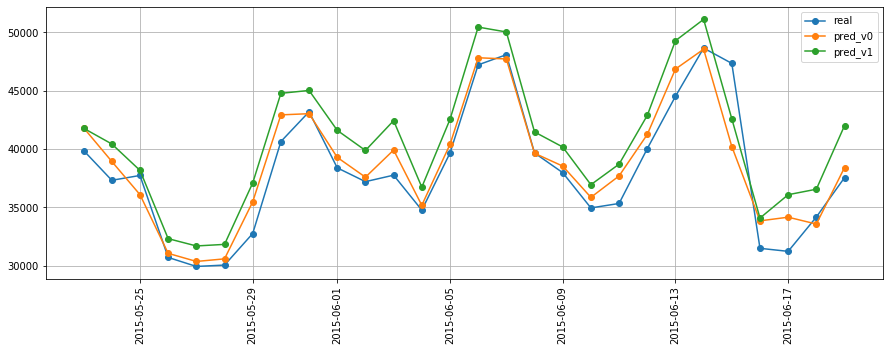

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Fitting the model
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.906938	valid_0's wrmsse: 1.01589
[50]	valid_0's wrmsseL12: 0.832845	valid_0's wrmsse: 0.583996
[75]	valid_0's wrmsseL12: 0.824358	valid_0's wrmsse: 0.507659
[100]	valid_0's wrmsseL12: 0.822539	valid_0's wrmsse: 0.488163
[125]	valid_0's wrmsseL12: 0.820878	valid_0's wrmsse: 0.477884
[150]	valid_0's wrmsseL12: 0.820379	valid_0's wrmsse: 0.475757
[175]	valid_0's wrmsseL12: 0.819807	valid_0's wrmsse: 0.475391
[200]	valid_0's wrmsseL12: 0.819432	valid_0's wrmsse: 0.475497
[225]	valid_0's wrmsseL12: 0.819209	valid_0's wrmsse: 0.476621
[250]	valid_0's wrmsseL12: 0.818948	valid_0's wrmsse: 

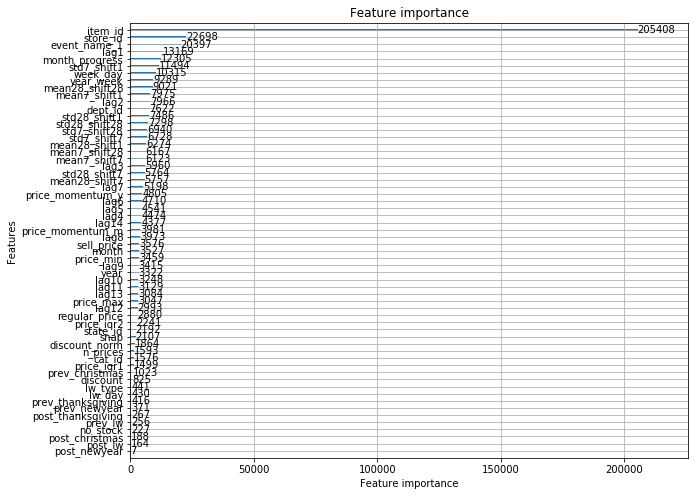

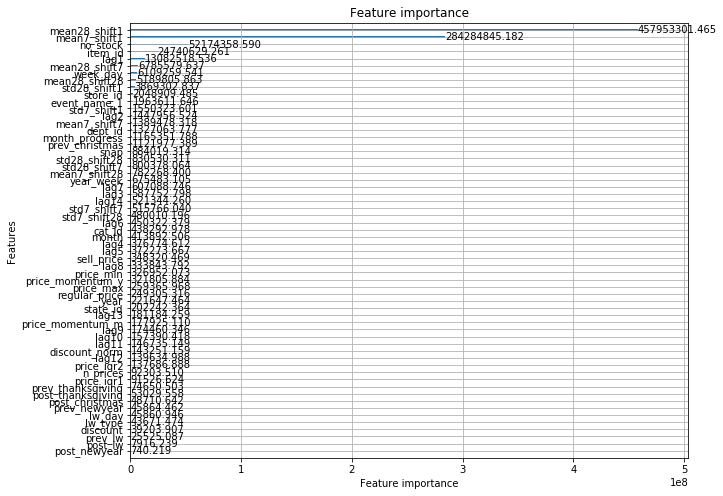

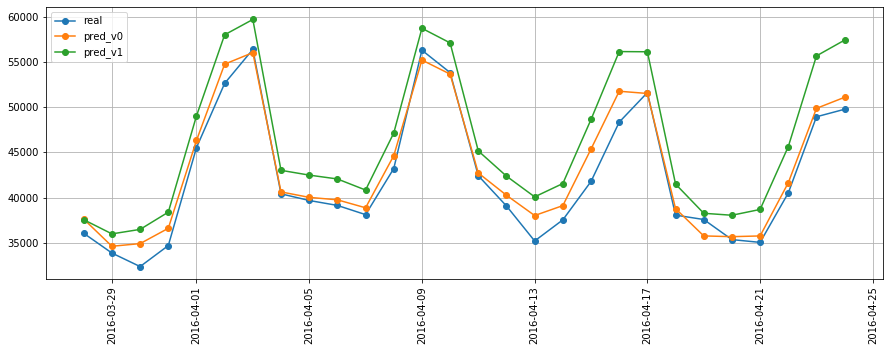

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.875508	valid_0's wrmsse: 1.08099
[50]	valid_0's wrmsseL12: 0.803524	valid_0's wrmsse: 0.63859
[75]	valid_0's wrmsseL12: 0.794345	valid_0's wrmsse: 0.536365
[100]	valid_0's wrmsseL12: 0.792274	valid_0's wrmsse: 0.507433
[125]	valid_0's wrmsseL12: 0.790836	valid_0's wrmsse: 0.492567
[150]	valid_0's wrmsseL12: 0.790215	valid_0's wrmsse: 0.485648
[175]	valid_0's wrmsseL12: 0.789806	valid_0's wrmsse: 0.483799
[200]	valid_0's wrmsseL12: 0.789446	valid_0's wrmsse: 0.482376
[225]	valid_0's wrmsseL12: 0.789177	valid_0's wrmsse: 0.480877
[250]	valid_0's wrmsseL12: 0.788948	valid_0's wrmsse: 0

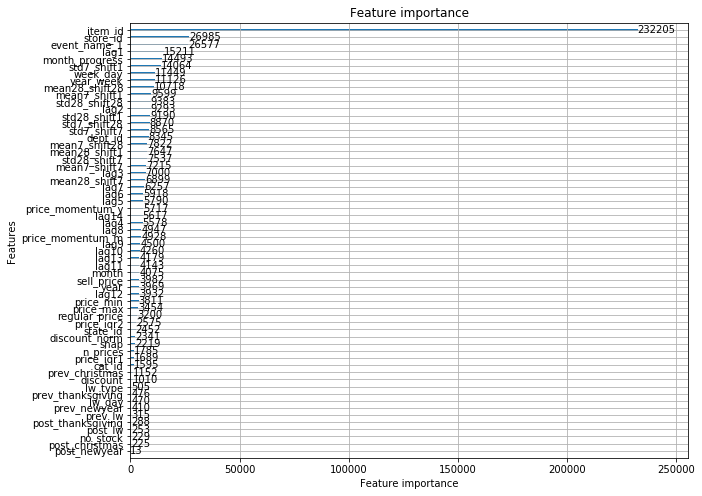

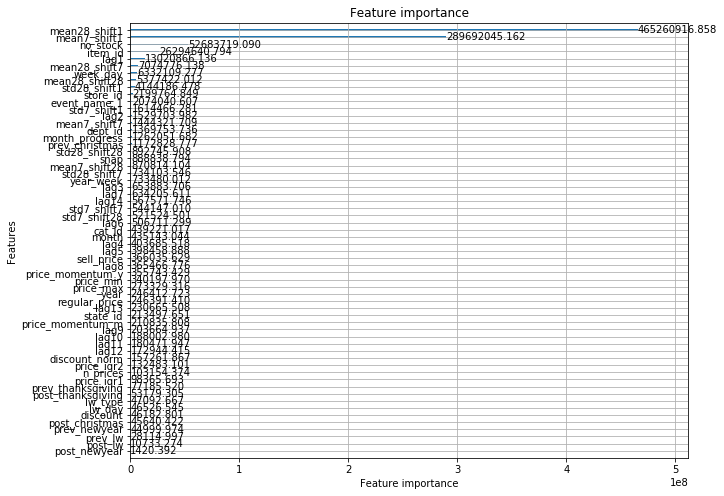

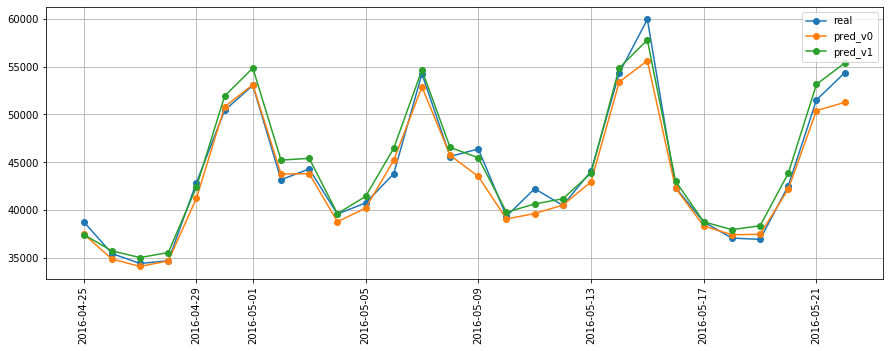

In [5]:
errors_v0 = dict()
errors_v1 = dict()

for i,valid_period in enumerate(valid_periods):

    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    logger.write("#"*100 + "\n")
    logger.write(f" Validation period: {valid_period} ".center(100, "#") + "\n")
    logger.write("#"*100 + "\n\n")

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
    model_level12.train_features.dropna(inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
    ts_id_in_train = model_level12.train_features.ts_id.unique()
    model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

    # needed to remove leakage of 'no_stock' feature
    no_stock_ts = list()
    for threshold in [28, 56, 84, 112, 140, 168]:
        left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
        no_stock_ts.append((model_level12.train_features
                            .query("ds >= @left_date")
                            .groupby(["ts_id"])
                            .filter(lambda x: np.all(x.y==0))
                            .loc[:, ["ts_id"]]
                            .drop_duplicates()))
    model_level12.valid_features["no_stock"] = 0
    for j,no_stock in enumerate(no_stock_ts):
        idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
        model_level12.valid_features.loc[idx, "no_stock"] = j+1
        
    logger.write(f"- training samples: {len(fcaster.train_features)} \n\n")
    logger.write(f"- validation samples: {len(fcaster.valid_features)} \n\n")
    logger.write(f"- ts in train set: {fcaster.train_features.ts_id.nunique()} \n\n")
    logger.write(f"- ts in valid set: {fcaster.valid_features.ts_id.nunique()} \n\n")
    logger.write(f"- input_features: {fcaster.input_features} \n\n")
    logger.flush()
    
    print("Fitting the model")
    tic = time.time()
    evaluator = Evaluator(model_level12.valid_features)
    model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    logger.write(f"- best_iteration: {fcaster.best_iteration} \n\n")
    logger.flush()

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))
    
    valid_dataframe = (model_level12.valid_features
                       .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                       .copy())
    evaluator = WRMSSEEvaluator(valid_dataframe)

    print("Predicting with ground thruth lagged values")
    tic = time.time()
    forecast_f4_v0 = (model_level12.valid_features
                      .loc[:, ["ds"]+model_level12.ts_uid_columns]
                      .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
    errors_v0[f"f{i}"] = evaluator.errors_by_level
    print("wrmsse:", wrmsse)
    print(evaluator.errors_by_level)
    
    logger.write(f"- wrmsse approach 1: {wrmsse} \n\n")
    logger.write(f"- all errors approach 1: \n{evaluator.errors_by_level} \n\n")
    logger.flush()

    print("Predicting with recursive approach")
    tic = time.time()
    def bias_corr_func(x):
        x[x < 0.1] = 0
        return x
    valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
    forecast_f4_v1 = model_level12.predict(valid_data, recursive=True, bias_corr_func=bias_corr_func)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
    errors_v1[f"f{i}"] = evaluator.errors_by_level
    print("wrmsse:", wrmsse)
    print(evaluator.errors_by_level)
    
    logger.write(f"- wrmsse approach 2: {wrmsse} \n\n")
    logger.write(f"- all errors approach 2: \n{evaluator.errors_by_level} \n\n")
    logger.flush()
    
    mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
           .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
    plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del model_level12, _train_data, _valid_index
    gc.collect()

***

In [ ]:
approach1 = [np.mean(list(list(errors_v0.values())[i].values())) for i in range(4)]
approach2 = [np.mean(list(list(errors_v1.values())[i].values())) for i in range(4)]

logger.write("#"*100 + "\n")
logger.write(f" Overall ".center(100, "#") + "\n")
logger.write("#"*100 + "\n\n")

logger.write(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)} \n\n")
logger.write(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)} \n\n")
logger.flush()

In [ ]:
print(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)}")
print(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)}")

***